# Image Compression


## Singular Value Decomposition (SVD)
$$ A = U\Sigma V^T $$
$$ U = \text{(mxm), columns are eigenvectors of } AA^T $$
$$ \Sigma = \text{(mxn), $r$ (rank(A)) singular values on diagonal } A^T A $$
$$ V = \text{(nxn), columns are eigenvectors of } A^T A $$

We also know what $\Sigma$ looks like 

$$
\Sigma = 
\begin{pmatrix}
    \sigma_1 && \\
    &\sigma_2  & \\
    && \ddots   \\
    &&& \sigma_r \\
    &&&& 0 \\
    &&&&& \ddots \\
    &&&&&& 0 \\
\end{pmatrix}
$$

This means that all columns $u_j \in U$ for $j > r$ can be removed because they will just be multiplied by zero. This also means that we will only need to multiply by the first $r$ rows of $V^T$ which equals the first $r$ columns of $V$.

So our reduced SVD becomes:
$$ A = \bar{U}\bar{\Sigma} \bar{V}^T $$
$$ \bar{U} = \text{(mxr)} $$
$$ \bar{\Sigma} = \text{(rxr)} $$
$$ \bar{V} = \text{(nxr)}$$

When singular values that are equal to zero exists we get a dimension reduction with no changes to our matrix. Another idea is to remove singular values that are close to zero and are not particularly "important" for reconstructing $A$.

In [1]:
from collections import Counter

%matplotlib inline
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import scipy as sp
from scipy import ndimage
import scipy.fftpack as fft

from ipywidgets import interact, FloatSlider

In [6]:
# Image Information
rgb_img = ndimage.imread("data/puppy.jpg")
gray_img = ndimage.imread("data/graycard.jpg",)

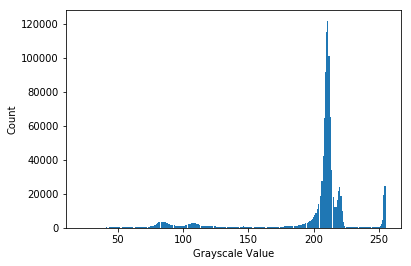

In [14]:
# Color frequencies (sorted)
plt.xlabel("Grayscale Value")
plt.ylabel("Count")
plt.hist(gray_img.flatten(), bins=256)
plt.show()

In [15]:
U, Sigma, Vh = sp.linalg.svd(gray_img)

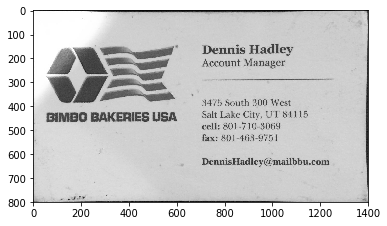

In [16]:
no_loss = np.dot(U, np.dot(sp.linalg.diagsvd(Sigma,gray_img.shape[0],gray_img.shape[1]), Vh))
plt.imshow(no_loss, cmap=plt.cm.gray)

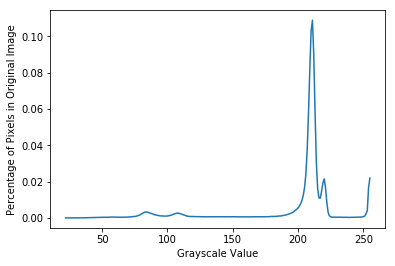

In [17]:
# Percentage of pixels in original image as a function of the grayscale pixel value

img_values, img_counts = np.unique(gray_img.flatten(), return_counts=True)
img_count_percs = img_counts/gray_img.flatten().size
plt.xlabel("Grayscale Value")
plt.ylabel("Percentage of Pixels in Original Image")
plt.plot(img_values, img_count_percs)

Bytes Used: 2201
Compression Ratio 0.00196517857143


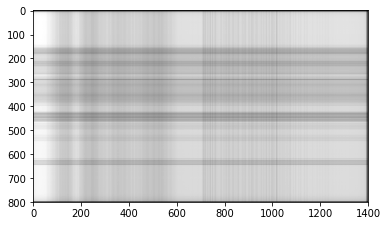

In [19]:
# See how the number of singular values used effects the visual quality of an 
# image and the amount of storage neeeded
U, Sigma, Vh = sp.linalg.svd(gray_img)

gray_img_svd_slider = FloatSlider(min=1, max=gray_img.shape[0], step=1, value=1)

# i is the number of singular values used to make the image
@interact(i=gray_img_svd_slider)
def plot_image_using_singular_values(i):
    i = int(i)
    total_bytes = np.matrix(U[:,:i]).size + Sigma[:i].size + np.matrix(Vh[:i, :]).size
    print("Bytes Used:", total_bytes)
    print("Compression Ratio", total_bytes/np.prod(gray_img.shape))
    
    U_1 = np.matrix(U[:,:i])
    Sigma_1 = np.diag(Sigma[:i])
    V_t = np.matrix(Vh[:i, :])
    
    result = U_1* Sigma_1 * V_t
    histogram_data = result.flatten().T
    
    #plt.hist(histogram_data, bins=256)
    plt.imshow(result, cmap=plt.cm.gray)

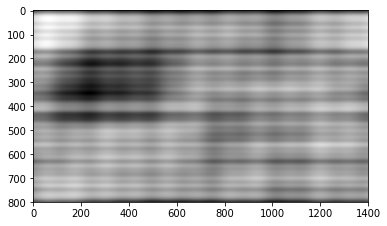

In [20]:
gray_img_fft_slider = FloatSlider(min=0, max=.01, step=0.000001, value=800)

img_fft = fft.fft2(gray_img)
M = np.max(np.abs(img_fft))
# i is the number of singular values used to make the image
@interact(i=gray_img_fft_slider)
def plot_image_using_fft2(i):
    truncated_image = (np.abs(img_fft) > M*i) * img_fft    

    #total_bytes = np.sum(np.abs(truncated_image > 0))
    #print("Bytes Used:", total_bytes)
    #print("Compression Ratio", total_bytes/num_pixels)
    
    reconstructed_image = np.real(fft.ifft2(truncated_image))
    
    #plt.hist(histogram_data, bins=256)
    plt.imshow(reconstructed_image, cmap=plt.cm.gray)

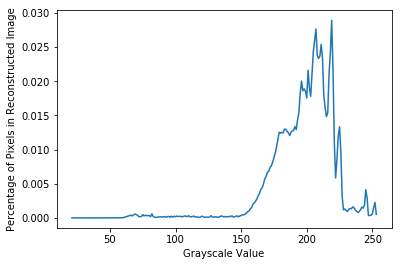

In [23]:
# See how the number of singular values used effects distribution of grayscale values
# used in the reconstructed image
U, Sigma, Vh = sp.linalg.svd(gray_img)
pdf_slider = FloatSlider(min=1, max=gray_img.shape[0], step=1, value=800)

def set_max(a):
        return a if (a<256) else 255

# i is the number of singular values used to make the image
@interact(i=pdf_slider)
def plot_reconstructed_image_pdf(i):
    i = int(i)

    approx_A = np.dot(U[:,:i], np.dot(np.diag(Sigma[:i]), Vh[:i, :]))
    approx_A_list = approx_A.flatten()
    approx_A_list = approx_A_list.astype(int)

    vfunc = np.vectorize(set_max)
    rounded_approx_A_list = vfunc(approx_A_list)

    approx_A_values, approx_A_counts = np.unique(rounded_approx_A_list, return_counts=True)
    approx_A_count_percs = approx_A_counts/np.prod(gray_img.shape)
    
    plt.xlabel("Grayscale Value")
    plt.ylabel("Percentage of Pixels in Reconstructed Image")
    plt.plot(approx_A_values, approx_A_count_percs)

## Compression Ratio vs Image Quality

We define the compression ratio as the amount of space required to store an image in its factorized form divided by the amount of space required to store the raw image (the matrix $A$ which is (mxn)). This can be written as a function of $i$, the number of singular values used.

$$ CompressionRatio = \frac{(m*i)+(i*i)+(i*n)}{m*n} $$

We can also quantify image quality. Informally we can think of it as the difference in absolute value between the original image, $A$, and the processed and reconstructed image, $B$. 

$$ Error = \frac{\sqrt{\sum_i \sum_j (a_{i,j}-b_{i,j})^2}}{\sqrt{\sum_i \sum_j a_{i,j}^2}} = \frac{||A-B||^2}{||A||^2}$$

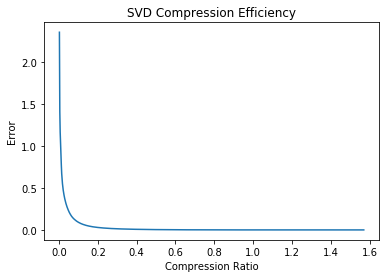

In [27]:
U, Sigma, Vh = sp.linalg.svd(gray_img)
compression_ratios = []
approximation_errors = []

for i in range(1,gray_img.shape[0]):
    compression_ratios.append((np.matrix(U[:,:i]).size + Sigma[:i].size + np.matrix(Vh[:i, :]).size)/np.prod(gray_img.shape))
    approx_A = np.dot(U[:,:i], np.dot(np.diag(Sigma[:i]), Vh[:i, :]))
    approximation_errors.append(((LA.norm(gray_img - approx_A)**2)/(LA.norm(gray_img)**2))*100)

plt.xlabel("Compression Ratio")
plt.ylabel("Error")
plt.title("SVD Compression Efficiency")
plt.plot(compression_ratios, approximation_errors)

In [28]:
# This may not (I don't think it is) a valid way to measure the compression ratio.
# If you still have to store zeros is that a reduction in space? (No?)
"""
fft_compression_ratios = []
fft_approximation_errors = []

img_fft = fft.fft2(gray_img)
M = np.max(np.abs(img_fft))
for thresh in np.arange(0,0.005,0.00001):
    truncated_image = (np.abs(img_fft) > M*thresh) * img_fft
    fft_compression_ratios.append(np.sum(np.abs(truncated_image > 0))/num_pixels)
    fft_approximation_errors.append(((LA.norm(img - np.real(fft.ifft2(truncated_image)))**2)/(LA.norm(img)**2))*100)

plt.xlabel("Compression Ratio")
plt.ylabel("Error")
plt.plot(fft_compression_ratios, fft_approximation_errors)
"""
print()

In [29]:
#plt.xlabel("Compression Ratio")
#plt.ylabel("Error")
#plt.plot(compression_ratios, approximation_errors,color='blue')
#plt.plot(fft_compression_ratios, fft_approximation_errors,color='red')

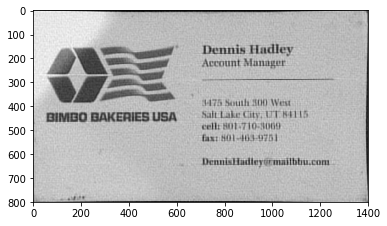

In [ ]:
fft_svd_slider = FloatSlider(min=1, max=gray_img.shape[0], step=1, value=1)

### USER DEFINED PARAMETERS ###
fft_thresh = 0.0003

# i is the number of singular values used to make the image
@interact(i=fft_svd_slider)
def plot_image_using_fft_singular_values(i):
    i = int(i)
    img_fft = fft.fft2(gray_img)
    M = np.max(np.abs(img_fft))
    
    truncated_fft_img = (np.abs(img_fft) > M*fft_thresh) * img_fft
    U_fft, Sigma_fft, Vh_fft = sp.linalg.svd(truncated_fft_img)
    
    
    U_fft_1 = np.matrix(U_fft[:,:i])
    Sigma_fft_1 = np.diag(Sigma_fft[:i])
    V_fft_t = np.matrix(Vh_fft[:i, :])
    
    reconstructed_fft_img = U_fft_1* Sigma_fft_1 * V_fft_t
    
    fully_reconstructed_img = np.real(fft.ifft2(reconstructed_fft_img))
    plt.imshow(fully_reconstructed_img, cmap=plt.cm.gray)

# Optimal Compression Subject to Cost Function

Cost function for error and compression ratios of the form $C = a\rho + bR$;
$\rho =$ Error and $R =$ compression ratio

In [10]:
def cost_function(error, compression_ratio):
    return error + compression_ratio

def optimal_compression(img, cost_function, img_type):
    m = img.shape[0]
    num_pixels = np.prod(img.shape)
    
    best_picture = img
    current_min = float('inf')
    
    
    if img_type == 'gray':
        U, Sigma, Vh = sp.linalg.svd(img)

        for i in range(1,m):
            compression_ratio = (np.matrix(U[:,:i]).size + Sigma[:i].size + np.matrix(Vh[:i, :]).size)/num_pixels
            approx_A = np.dot(U[:,:i], np.dot(np.diag(Sigma[:i]), Vh[:i, :]))
            error = ((LA.norm(img - approx_A)**2)/(LA.norm(img)**2))*100

            func_val = cost_function(error, compression_ratio)
            if func_val < current_min:
                best_picture = approx_A

        return best_picture
    
    if img_type == 'rgb':
        red = img[:, :, 0]
        green = img[:, :, 1]
        blue = img[:, :, 2]
        
        red_U, red_S, red_V = sp.linalg.svd(red)
        green_U, green_S, green_V = sp.linalg.svd(green)
        blue_U, blue_S, blue_V = sp.linalg.svd(blue)
        
        for i in range(1,m):
            compression_ratio = ((np.matrix(red_U[:,:i]).size + red_S[:i].size + np.matrix(red_V[:i, :]).size)*3)/num_pixels
            rgbArray = np.zeros(img.shape, 'uint8')
            for ix, color_matrix in enumerate([[red_U, red_S, red_V], [green_U, green_S, green_V], [blue_U, blue_S, blue_V]]):
                rgbArray[:,:, ix] = np.dot(color_matrix[0][:,:i], np.dot(np.diag(color_matrix[1][:i]), color_matrix[2][:i, :]))
            error = ((LA.norm(img - rgbArray)**2)/(LA.norm(img)**2))*100

            func_val = cost_function(error, compression_ratio)
            if func_val < current_min:
                best_picture = rgbArray
        return best_picture        
        

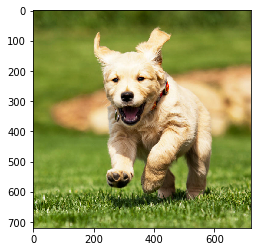

In [12]:
plt.imshow(optimal_compression(rgb_img, cost_function, 'rgb'), cmap=plt.cm.gray)

Bytes Used: 220473
Compression Ratio 0.141765046296


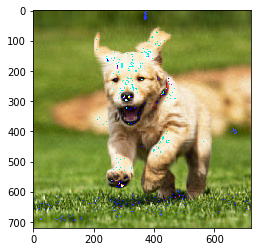

In [9]:
color_svd_slider = FloatSlider(min=1, max=rgb_img.shape[0], step=1, value=1)

# i is the number of singular values used to make the image
@interact(i=color_svd_slider)
def plot_image_using_singular_values(i):
    i = int(i)
    total_bytes = 0
    
    red = rgb_img[:, :, 0]
    green = rgb_img[:, :, 1]
    blue = rgb_img[:, :, 2]
    
    rgbArray = np.zeros(rgb_img.shape, 'uint8')
    for ix, color_matrix in enumerate([red, green, blue]):
        U, S, V = sp.linalg.svd(color_matrix)
        total_bytes += np.matrix(U[:,:i]).size + S[:i].size + np.matrix(V[:i, :]).size
        rgbArray[:,:, ix] = np.dot(U[:,:i], np.dot(np.diag(S[:i]), V[:i, :]))
        
    print("Bytes Used:", total_bytes)
    print("Compression Ratio", total_bytes/np.prod(rgb_img.shape))
    
    plt.imshow(rgbArray, cmap=plt.cm.gray)